In [37]:
import torch
import numpy as np
import pickle
import pandas as pd
import os
from sklearn import metrics
import matplotlib.pyplot as plt

In [44]:
def one_hot_encode(y, K=5):
    """
    one_hot_encode encodes y in one-hot encoding

    param y (int): int y must be in the range [1,5]
    param K (int): int K is the number of classes
    return: one-hot encoded list of K length, with the only
    non-zero, or 1 value, being the index of y - 1. 
    """
    encoded_y = [0] * K
    encoded_y[y-1] = 1
    return encoded_y

def one_hot_decode(y):
    """
    one_hot_decode decodes y from one-hot to integer value

    param y (np.array): np.array y must be encoded using one-hot encoding
    return (int): int index + 1 of where y == 1, or the decoded y
    """
    return np.where(y == 1)[0].item() + 1

def get_data(data_dir, anno_csv):
    """
    Return data _X and label_Y from the annotation csvs or raw files
    as numpy arrays.
    """
    # First read the annotation csv
    data_pd = pd.read_csv(os.path.join(data_dir, anno_csv))
    label_Y = []
    
    # Encode Y
    for y in data_pd['Label']:
        label_Y.append(one_hot_encode(y, 5))
    
    label_Y = np.array(label_Y)

    # Load the data numpy arrays from the file names into the data_X list
    data_X = []
    for file_name in data_pd['Image Name']:
        data_X_path = os.path.join(data_dir, file_name)
        data_point = np.load(data_X_path)
        data_point = np.append(data_point, [1]) # Add the extra 1
        data_X.append(data_point)

    data_X = np.array(data_X) # Convert to a numpy array

    return data_X, label_Y


def train_mine(X, gt_Y, dir, train_anno, test_anno):
    """
    Function trains multiclass classification learning model on MNIST dataset digits of 1-5
    and saves learned parameters.
    """
    # Define the constants
    feature_length = 784
    total_class = 5
    max_epoch = 10
    learning_rate = 0.68
    show_accuracies = True

    # Specifying the device to GPU/CPU. Here, 'cuda' means using 'gpu' and 'cpu' means using cpu only
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    epochs = np.arange(0, max_epoch)

    #Initialize Theta Matrix W
    W = np.random.rand(feature_length+1, total_class)

    losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in epochs:
        '''Compute the loss, gradient of loss with respect to W, 
        and update W with gradient descent/stochastic gradient descent method.
        Observe the loss for each epoch, it should decrease with each epoch.'''

        # Calculate the loss and gradient descent in one loop
        loss_sum = 0
        M = len(X)
        Theta_gradient = []
        for k in range(total_class):
            gradient_sum = np.zeros(feature_length+1)
            for m in range(M):                
                # Sum the losses
                softmax_result = softmax(X[m][:-1], k, W)
                loss_sum += gt_Y[m][k].item() * np.log(softmax_result)

                # Sum the gradient
                gradient_sum += (gt_Y[m][k].item() - softmax_result)*X[m]
            
            # Append the kth gradient to the gradient list
            Theta_gradient.append(-gradient_sum / M)
            
        normalized_loss = -loss_sum / M # Normalize and negate the loss
        losses.append(normalized_loss)
        Theta_gradient_np = np.transpose(np.array(Theta_gradient)) # Tranpose to match dims
        
        # Now update the Theta Matrix W
        W = W - (learning_rate * Theta_gradient_np)

        print(f"Epoch {epoch:<3} | Loss: {normalized_loss:6f} | ", end='')
        
        if show_accuracies:
            # Get accuracy for training data
            train_accuracy = test_mine(dir, train_anno, W, False)
            train_accuracies.append(train_accuracy)

            # Get accuracy for testing data
            test_accuracy = test_mine(dir, test_anno, W, False)
            test_accuracies.append(test_accuracy)
            print(f"Train Accuracy: {train_accuracy:6f} | Test Accuracy: {test_accuracy:6f}", end='')
        print()

    # Save the converged Theta (W)
    filehandler = open("multiclass_parameters.txt", "wb")
    pickle.dump(W, filehandler)
    filehandler.close()

    # Plot the losses
    line_plot(epochs, losses, "Epochs", "Loss", "./plots/")

    # Plot the accuracies
    line_plot(epochs, train_accuracies, "Epochs", "Test and Train Accuracy", "./plots/", test_accuracies)

    return

def test_mine(test_dir, anno_csv, W = np.array([0]), final_test = True):
    """
    test_mine tests the parameters in "multiclass_parameters.txt" by using them
    to predict what digit, from 1-5, the test images are, and returns the final
    model accuracy.

    W is the weight matrix
    """
    # Specifying the device to GPU/CPU. Here, GPU means 'cuda' and CPU means 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if final_test:
        filehandler = open("multiclass_parameters.txt", "rb")
        W = pickle.load(filehandler)

    # Read the data and labels from the testing data
    X, gt_Y = get_data(data_dir=test_dir, anno_csv=anno_csv)

    # Predict Y using X and updated W.
    Y = pred(X, W)

    # Calculate accuracy
    accuracy, prediction_errors = calc_accuracies(Y, gt_Y, final_test)

    if final_test:
        # Plot the different accuracies in a bar plot
        class_num = len(gt_Y[0]) + 1 
        class_list = [n for n in range(1, class_num)]
        barplot = plt.figure()
        plt.bar(class_list, prediction_errors, color='firebrick')
        plt.xlabel("Digits")
        plt.ylabel("Classification Errors")
        plt.title("Classification Errors of Handwritten Digits 1-5")
        plt.savefig('./plots/class_errors_barplot.png')
        plt.show()

        # Plot the confusion matrix
        decoded_gt_Y = one_hot_decode_array(gt_Y)
        decoded_Y = one_hot_decode_array(Y)        
        cm_fig = plt.figure()
        confusion_matrix = metrics.confusion_matrix(decoded_gt_Y, decoded_Y)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                                    display_labels=[n for n in range(1,6)])
        cm_display.plot()
        plt.savefig('./plots/class_confusion_matrix.jpg')
    return accuracy

def softmax(x, k, Theta):
    """
    softmax calculates the probability that x is class k using the
    parameters in Theta.

    param x (np.array float): np.array of a sample image with a shape of (784x1)
    param k (int): the class k
    param Theta (np.array float): The parameter matrix, shape of 785x5
    return float: the softmax result, between 0 and 1 
    """
    K = len(Theta[0]) # Total number of classes
    w_k = Theta[:-1, k] # kth Weight list, or vector
    w_k0 = Theta[-1, k] # kth Bias
    numerator = np.exp(np.dot(w_k, x) + w_k0) # Calculate the numerator
    
    # Sum the denominator over all K classes
    denominator = 0
    for j in range(K):
        w_j = Theta[:-1, j] # jth Weight list, or vector
        w_j0 = Theta[-1, j] # jth bias
        denominator += np.exp(np.dot(w_j, x) + w_j0)
    
    # Calculate the softmax result
    softmax_result = numerator/denominator
    
    return softmax_result

def pred(X,Theta):
    '''
    pred predicts Y from X and Theta

    param X (np.array float): The data matrix X, shape of Mx785 (M being sample #)
    param Thera (np.array float): The parameter matrix, shape of 785x5
    return (np.array int): Y matrix of encoded y predictions (M number of predictions)
    '''
    # Apply the softmax function to each k and find the max
    K = len(Theta[0]) # Total number of classes

    # Iterate over each datum x to predict find the max probability and predict its
    # respective y, which is stored in the larger matrix Y
    Y = []
    for x in X:
        # Construct a list of probabilities of each class 1-5 in respective indices 0-4
        probabilities = []
        for k in range(K):
            probabilities.append(softmax(x[:-1], k, Theta))
        probabilities = np.array(probabilities)
        
        # Find the prediction y, which is the max probability
        y = np.argmax(probabilities) + 1
        
        # encode y
        y_encoded = one_hot_encode(y, K)
        Y.append(y_encoded)

    return np.array(Y)

def visualize_weights(class_num, W = np.array([0]), final_visualize = True):
   """
   visualize_weights visualizes the weights, W,
   in class_num number of plots
   """
   if (final_visualize):
        filehandler = open("multiclass_parameters.txt", "rb")
        W = pickle.load(filehandler)
    
   plot_dir = "./plots/"
   for k in range(class_num):
        fig = plt.figure()
        img = W[:-1, k].reshape(28,28)
        plt.imshow(img) 
        plt.colorbar() 
        plot_filename = 'weight' + str(k+1) + '_plot.png'
        plt.savefig(os.path.join(plot_dir, plot_filename))
        plt.show()

def calc_accuracies(prediction, label, final_test = False):
    """
    calc_accuracies calculates the accuracies of the predictions,
    and the prediction errors.
    """
    if prediction.shape != label.shape:
        print("ERROR: Prediction and label are not the same shape")
        exit(1)
    
    # Find number of correct predictions
    label_type_num = len(prediction[0])
    correct_predictions = [0]*label_type_num
    
    if final_test:
        label_counts = [0]*label_type_num

    for m in range(len(prediction)):
        prediction_decoded = one_hot_decode(prediction[m])
        label_decoded = one_hot_decode(label[m])
        
        if final_test:
            # Count the number of labels of each type
            label_counts[label_decoded - 1] += 1

        # Count the number of correct prediction
        if prediction_decoded == label_decoded:
            correct_predictions[label_decoded - 1] += 1

    # Calculate the prediction errors for each class
    prediction_errors = []
    if final_test:
        for k in range(len(label_counts)):
            if label_counts[k] == 0:
                pred_error = 0
            else:
                pred_error = (label_counts[k] - correct_predictions[k]) / label_counts[k]
            prediction_errors.append(pred_error)

    return sum(correct_predictions) / len(prediction), prediction_errors

def one_hot_decode_array(Y):
    '''
    one_hot_decode decodes an array Y of one_hot_encoded lists,
    returns the decoded Y
    '''
    decoded_Y = []
    for y in Y:
        decoded_Y.append(one_hot_decode(y))
    return decoded_Y

def line_plot(xvals0, yvals, xlabel, ylabel, dir, xvals1 = []):
    """
    line_plot Creates a line plot of the xvals vs yvals
    """
    fig = plt.figure()
    
    if xvals1:
        plt.plot(xvals0, yvals, label = "Train Accuracy")
        plt.plot(xvals1, label = "Test Accuracy")
        plt.legend()
        ylabel = "Accuracy"
    else:
        plt.plot(xvals0, yvals)
    
    plt.title(f"{ylabel} vs {xlabel}")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    file_path = os.path.join(dir, f"{ylabel}_vs_{xlabel}_plot.png")
    plt.savefig(file_path)


In [39]:
# if __name__ == "__main__":
train_dir = './'
train_anno_file = './data_progS24/labels/train_anno.csv' # specify your training data label directory
test_dir = './' # specify your test data directory
test_anno_file = './data_progS24/labels/test_anno.csv' # specify your test label directory
X, gt_Y = get_data(train_dir, train_anno_file)

Epoch 0   | Loss: 3.287457 | Train Accuracy: 0.439192 | Test Accuracy: 0.449774
Epoch 1   | Loss: 2.520613 | Train Accuracy: 0.514654 | Test Accuracy: 0.509292
Epoch 2   | Loss: 1.630687 | Train Accuracy: 0.515172 | Test Accuracy: 0.519839
Epoch 3   | Loss: 1.423160 | Train Accuracy: 0.616518 | Test Accuracy: 0.618785
Epoch 4   | Loss: 1.358644 | Train Accuracy: 0.604253 | Test Accuracy: 0.606981
Epoch 5   | Loss: 1.328670 | Train Accuracy: 0.682622 | Test Accuracy: 0.687343
Epoch 6   | Loss: 1.576380 | Train Accuracy: 0.732040 | Test Accuracy: 0.740834
Epoch 7   | Loss: 0.845833 | Train Accuracy: 0.773415 | Test Accuracy: 0.774736
Epoch 8   | Loss: 0.657427 | Train Accuracy: 0.771982 | Test Accuracy: 0.781266
Epoch 9   | Loss: 0.670969 | Train Accuracy: 0.768159 | Test Accuracy: 0.774485


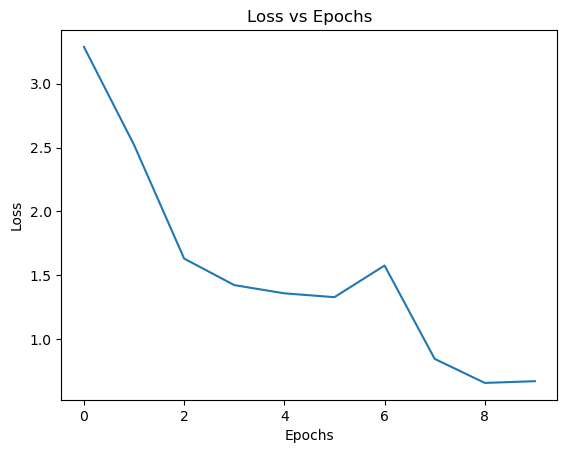

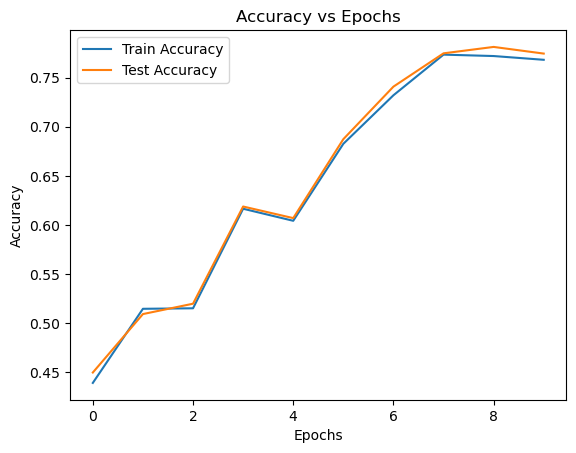

In [40]:
train_mine(X, gt_Y, train_dir, train_anno=train_anno_file, test_anno=test_anno_file)

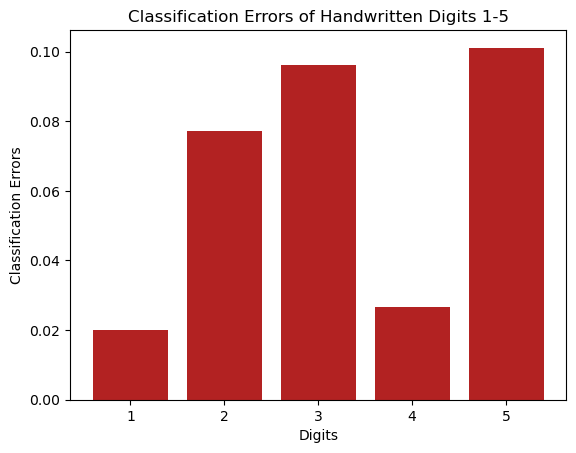

0.9367152184831743

<Figure size 640x480 with 0 Axes>

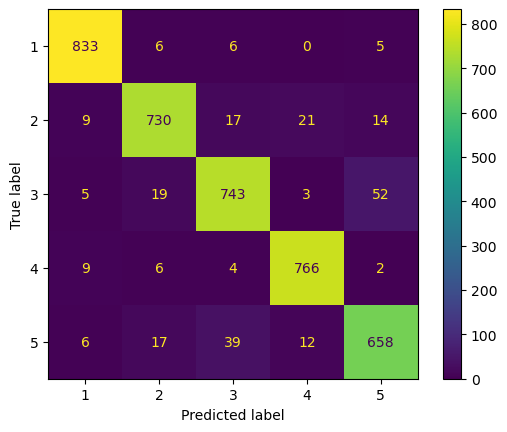

In [47]:
#Load the Weight Matrix that has been saved after training
test_mine(test_dir, test_anno_file)

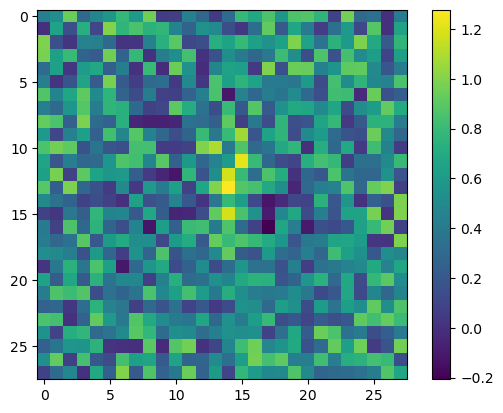

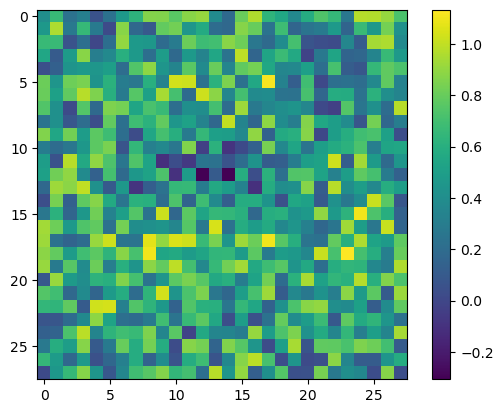

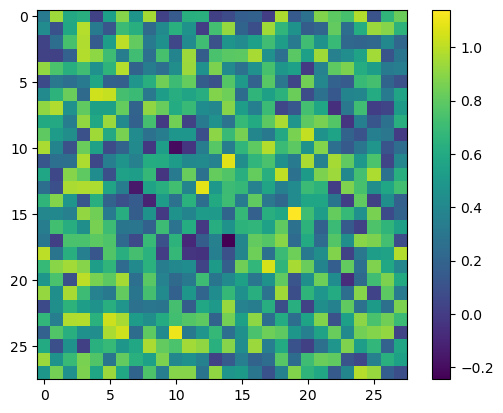

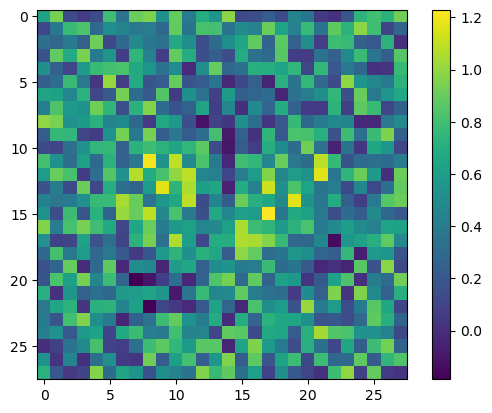

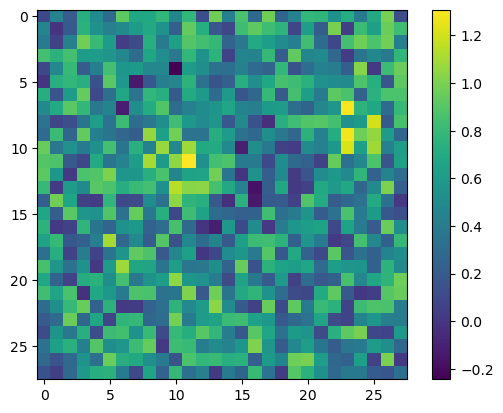

In [46]:
visualize_weights(5)